In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import and visualize data

In [58]:
# process outflow data
outflow_data = pd.read_csv('4200 Modified Average Daily Streamflows.csv')
outflow_data.rename(columns={'Ice Harbor Daily Streamflows (unit:cfs)': 'Ice Harbor outflow (cfs)'}, inplace=True)
outflow_data.rename(columns={'Lower Monumental (unit:cfs)': 'Lower Monumental outflow (cfs)'}, inplace=True)
outflow_data.rename(columns={'Little Goose (unit:cfs)': 'Little Goose outflow (cfs)'}, inplace=True)
outflow_data.rename(columns={'Lower Granite (unit:cfs)': 'Lower Granite outflow (cfs)'}, inplace=True)
outflow_data['date'] = pd.to_datetime(outflow_data['date'])
outflow_data.rename(columns={'date':'datetime'}, inplace=True)

# process precipitation data for runoff calculations
precip_data = pd.read_csv('NOAAprecipitation_data_LEWISTON_AIRPORT_ID.csv')
precip_data = precip_data.drop(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'SNWD', 'SNOW'], axis=1)
precip_data.rename(columns={'PRCP':'rainfall (in)', 'DATE':'datetime'}, inplace=True)
precip_data['datetime'] = pd.to_datetime(precip_data['datetime'], format='%Y-%m-%d')

# process upstream flow
upstream_flow = pd.read_csv('nwis.waterdata.usgs.gov.txt', sep='\t', header=27)
upstream_flow = upstream_flow.drop(0)
upstream_flow['datetime'] = pd.to_datetime(upstream_flow['datetime'], format='%Y-%m-%d %H:%M').dt.date
upstream_flow = upstream_flow.drop(['agency_cd', 'site_no', 'tz_cd', '191671_00060_cd'], axis=1)
upstream_flow.rename(columns={'191671_00060':'upstream flow (cfs)'}, inplace=True)
upstream_flow['upstream flow (cfs)'] = pd.to_numeric(upstream_flow['upstream flow (cfs)'], errors='coerce')
upstream_flow = upstream_flow.groupby('datetime')['upstream flow (cfs)'].mean().reset_index()
upstream_flow['datetime'] = pd.to_datetime(upstream_flow['datetime'])

# merge the dataframes
flow_data = outflow_data.merge(upstream_flow, how='inner', on=['datetime'])
input_data = flow_data.merge(precip_data, how='inner', on=['datetime'])

display(input_data)


/var/folders/g8/67bmljw57jq202ggfmzpdkvm0000gn/T/ipykernel_37903/2665267026.py:17: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  upstream_flow = pd.read_csv('nwis.waterdata.usgs.gov.txt', sep='\t', header=27)


,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in)
0,1987-10-01,16126,17137,17079,17204,4480.312500,0.0
1,1987-10-02,16102,16800,16749,16536,2892.886598,0.0
2,1987-10-03,16556,17219,17169,17231,2843.195876,0.0
3,1987-10-04,18588,19306,19257,19282,2829.072165,0.0
4,1987-10-05,15773,16437,16387,16323,2805.979381,0.0
...,...,...,...,...,...,...,...
10176,2018-09-26,17428,18068,17945,17918,2992.083333,0.0
10177,2018-09-27,17526,18607,18484,18519,2978.105263,0.0
10178,2018-09-28,17245,18291,18170,18192,2962.187500,0.0
10179,2018-09-29,17863,18637,18515,18493,2935.416667,0.0


### Visualize one year

Text(0, 0.5, 'Outflow data from each dam (cfs)')

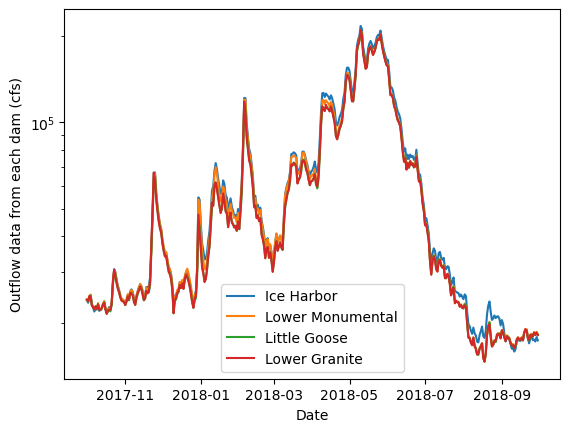

In [ ]:
sns.lineplot(x='datetime', y='Ice Harbor outflow (cfs)', data=outflow_data[-365:], label='Ice Harbor')
sns.lineplot(x='datetime', y='Lower Monumental outflow (cfs)', data=outflow_data[-365:], label='Lower Monumental')
sns.lineplot(x='datetime', y='Little Goose outflow (cfs)', data=outflow_data[-365:], label='Little Goose')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=outflow_data[-365:], label='Lower Granite')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Outflow data from each dam (cfs)')

### Visualize entire dataset

Text(0, 0.5, 'Outflow data from each dam (cfs)')

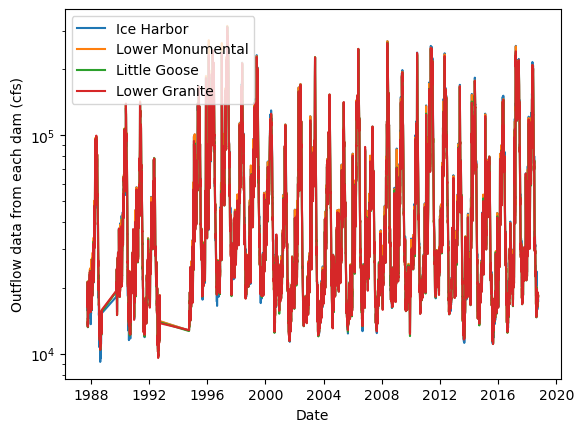

In [61]:
sns.lineplot(x='datetime', y='Ice Harbor outflow (cfs)', data=input_data, label='Ice Harbor')
sns.lineplot(x='datetime', y='Lower Monumental outflow (cfs)', data=input_data, label='Lower Monumental')
sns.lineplot(x='datetime', y='Little Goose outflow (cfs)', data=input_data, label='Little Goose')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=input_data, label='Lower Granite')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Outflow data from each dam (cfs)')

## Simulate reservoirs

In [4]:
x = 0
res_info = pd.DataFrame({'Names':['Ice Harbor','Lower Monumental','Little Goose','Lower Granite'],
                         'Reservoir surface area (m^2)':[9200*4047,6590*4047,10025*4047,8900*4047],
                         'Number of turbines':[6,6,6,6],
                         'Generation capacity (kW)':[603000,810000,903000,810000],
                         'Average tailwater elevation (m)':[x,x,x,x],
                         'Maximum pooling elevation (m)':[x,x,646.5,x],
                         'Fish Passage Rate (%)':[.965,.965,.9775,x],
                         'Watershed Area (acres)':[103_352,95_277,83_074,111_602]
                         })
res_info['Generation capacity (kW)'] = pd.to_numeric(res_info['Generation capacity (kW)'])
display(res_info)

eta = 0.8 # efficiency of turbines, assumed value
rho = 998 # density of water, 1000 kg/m^3
g = 9.81 # gravitational acceleration, 9.81 m/s^2

# generate inflow from previous reservoir outflow/gage data, and added runoff data
# PLACEHOLDER
def simulate_inflow(data):
    return data*1.1

# simulate reservoir
def simulate_reservoir(df, initial_storage, keep, resID):
    # df is a dataframe containing reservoir data. Has columns 'inflow (cfs)'
    #       and 'outflow (cfs)'. Timestep is in days.
    # keep is a boolean. Keep = 0, remove = 1
    # resID is the string name of the reservoir
    # this function will directly modify a DataFrame!
    info = res_info[res_info['Names'] == resID].iloc[0]
    df['storage (cf)'] = 0
    max_storage = info['Maximum pooling elevation (m)']*info['Reservoir surface area (m^2)']
    df.loc[0,'storage (cf)'] = initial_storage
    if keep == 0:
        df['storage (cf)'] = df['storage (cf)'].cumsum() + (df['inflow (cfs)'] - df['outflow (cfs)'])*86400
        df['storage (m^3)'] = np.minimum(df['storage (cf)']/35.315,max_storage)
        df['elevation head (m)'] = df['storage (m^3)']/info['Reservoir surface area (m^2)']
        df['power produced (kWh)'] = np.minimum(eta*rho*g*df['elevation head (m)']*df['storage (cf)']*info['Number of turbines'], info['Generation capacity (kW)'])
    else:
        df['storage (cf)'] = 0
        df['elevation head (m)'] = 0
        df['power produced (kWh)'] = 0
        df['outflow (cfs)'] = df['inflow (cfs)']

    return None

# simulate the whole system
def simulate_system(df):
    # - df is dataframe with Ice Harbor, Lower Monumental, Little Goose, and Lower Granite
    return None

,Names,Reservoir surface area (m^2),Number of turbines,Generation capacity (kW),Average tailwater elevation (m),Maximum pooling elevation (m),Fish Passage Rate (%),Watershed Area (acres)
0,Ice Harbor,37232400,6,603000,0,0.0,0.9650,103352
1,Lower Monumental,26669730,6,810000,0,0.0,0.9650,95277
2,Little Goose,40571175,6,903000,0,646.5,0.9775,83074
3,Lower Granite,36018300,6,810000,0,0.0,0.0000,111602


In [71]:
import reservoir_simulation

# simulate Little Goose reservoir
little_goose = pd.DataFrame(outflow_data['Little Goose outflow (cfs)'])
little_goose['inflow (cfs)'] = simulate_inflow(little_goose['Little Goose outflow (cfs)'])
little_goose.rename(columns={'Little Goose outflow (cfs)':'outflow (cfs)'}, inplace=True)
display(little_goose)
simulate_reservoir(little_goose,100000,0,'Little Goose')
display(little_goose)

,outflow (cfs),inflow (cfs)
0,57767,63543.7
1,50879,55966.9
2,46984,51682.4
3,45671,50238.1
4,42425,46667.5
...,...,...
32959,17945,19739.5
32960,18484,20332.4
32961,18170,19987.0
32962,18515,20366.5


,outflow (cfs),inflow (cfs),storage (cf),storage (m^3),elevation head (m),power produced (kWh)
0,57767,63543.7,4.992069e+08,1.413583e+07,0.348421,903000.0
1,50879,55966.9,4.396946e+08,1.245065e+07,0.306884,903000.0
2,46984,51682.4,4.060418e+08,1.149771e+07,0.283396,903000.0
3,45671,50238.1,3.946974e+08,1.117648e+07,0.275478,903000.0
4,42425,46667.5,3.666520e+08,1.038233e+07,0.255904,903000.0
...,...,...,...,...,...,...
32959,17945,19739.5,1.551448e+08,4.393170e+06,0.108283,903000.0
32960,18484,20332.4,1.598018e+08,4.525039e+06,0.111533,903000.0
32961,18170,19987.0,1.570888e+08,4.448217e+06,0.109640,903000.0
32962,18515,20366.5,1.600696e+08,4.532624e+06,0.111720,903000.0
